# Omega Centauri Gamma Ray spectrum with DM annihilation 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
import scipy.optimize as op
from astropy.io import ascii
from scipy.integrate import quad
from scipy import interpolate


###Read data
data_all=ascii.read('GammaPythia.dat')

In [2]:
###Define a Chisqare function

def ChiSq(func,arg,x,y,yerr):
    model=func(x,arg)
    inv_sigma2 = 1.0/np.power(yerr,2.)
    chisq=0.5*(np.sum((np.power(y-model,2.)*inv_sigma2))) 
    return chisq

In [289]:
###DEfine the interpolating function of the spectra given by the Pythia Tables, given a mass I have to select from pythia Data the correct 
#energy spectrum
#
#The columns are  [ mDM, Log10x , dN/d Log10x for 28 primary channels]
#(DM DM --> eL+eL-, eR+eR-, e+e-, μL+μL-, μR+μR-, μ+μ -, τL+τL-, τR+τR-,τ+τ -, qq, cc, bb, tt, WL+WL-, WT+WT-,W+W-, ZL+ZL-, ZT+ZT-, Z+Z-, gg, γγ, hh, νeνe, νμνμ, ντντ, VV → 4e, VV → 4μ, VV →	4τ.)].

#data_arrays=np.vsplit(data_all,180)
#print data_arrays
def pick_mass(mass,state):
    x=(10**data_all[(data_all['col1']==mass)]['col2'])*mass
    y=(data_all[(data_all['col1']==mass)][state])
    return x,y

def interp(mass,col_secpart):
    masslist=[5,6,8,10,15,20,25,30,40,50,60,70,80,90,100,110,120,130,140,150]
    if (mass<5 or mass>150):
        return 0.
    if mass in masslist:
        index=masslist.index(mass)
        x=(10**data_all[(data_all['col1']==mass)]['col2'])*mass
        y=(data_all[(data_all['col1']==mass)][col_secpart])
        return x,y
    else:
        index=np.searchsorted(masslist,mass)
        mass1=masslist[index]
        mass2=masslist[index+1]
        print mass1,mass,mass2
        
        x1=(10**data_all[(data_all['col1']==mass1)]['col2'])*mass1
        x2=(10**data_all[(data_all['col1']==mass2)]['col2'])*mass2
        y1=(data_all[(data_all['col1']==mass1)][col_secpart])
        y2=(data_all[(data_all['col1']==mass2)][col_secpart])
 
        x=np.append(x2,x1)
        y=np.append(y2,y1)
        idx=np.argsort(x)
        x=x[idx]
        y=y[idx]
    #tck = interpolate.splrep(x, y,s=0)
        tck = interpolate.interp1d(x, y)
        xnew=(10**data_all[(data_all['col1']==mass1)]['col2'])*mass
        xnew[xnew<min(x)]=min(x)
        #print min(x),min(xnew)
    #ynew=interpolate.splev(xnew,tck)
        #ynew=tck(xnew)
        #ynew[np.isnan(ynew)]=0.
        #ynew[ynew<1e-7]=0.
        return tck#xnew,ynew



50 45 60
6.29462705897e-08 6.29462705897e-08


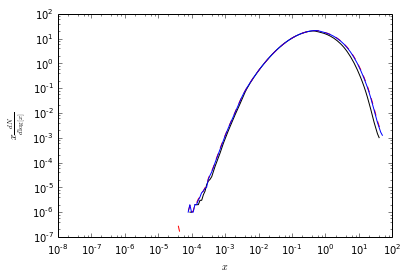

In [281]:
testx,testy=interp(45,'col14')
datax,datay=pick_mass(40,'col14')
data2x,data2y=pick_mass(50,'col14')
pl.plot(datax,datay,'k')
pl.plot(testx,abs(testy),'--r')
pl.plot(data2x,data2y,'b')
pl.xscale('log')
pl.yscale('log')
#pl.xlim(2e2,2e4)
pl.xlabel('$x$')
pl.ylabel(r'$x\frac{dN}{d\log[x]}$')
#pl.ylim(1e-7,100)
#testy
pl.show()

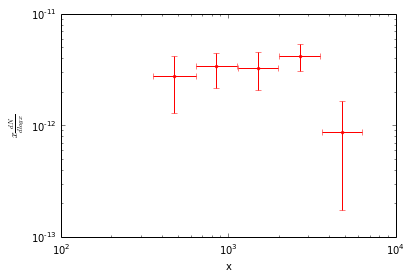

In [220]:
mdm=100e3
data=ascii.read('Ocent_gamma.dat')
x=data['col1']
y=data['col2']
dy_up=data['col3']-data['col2']
dy_low=data['col2']-data['col4']
yerr=dy_up+dy_low
dx_low=data['col1']-data['col6']
dx_up=data['col5']-data['col1']
fig1=pl.figure()
ax1 = fig1.add_subplot(111)
ax1.errorbar(x,y,xerr=[dx_low,dx_up],yerr=[dy_low,dy_up],fmt='.r')
ax1.set_xscale('log')
ax1.set_yscale('log')
#ax1.set_ylim([1e-13,5e-11])
#ax1.set_xlim([100,20000])
ax1.set_xlabel('x')
ax1.set_ylabel(r'$x \frac{dN}{dlog x}$')

0.209685823996


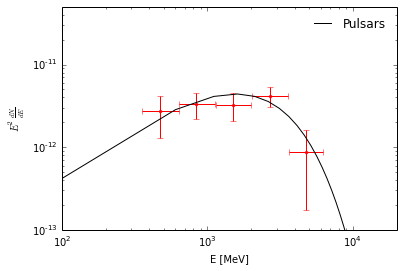

In [6]:
En=np.linspace(100,50000,100)
def E2dNdEpulsar(x,N0):
    ###Here I have to find out where the normalization comes from, for now I'm 
    ##using this value that seems to reproduce the FERMI paper.  This normalization is set by the best fit value. 
    return N0*(x/100.)**2.*(x/100.)**(-0.7)*np.exp(-(x/1.2e3))

ax1.plot(En,E2dNdEpulsar(En,4.54804687e-13),'black',label='Pulsars')
ax1.legend(loc='upper right',frameon=False)

print(ChiSq(E2dNdEpulsar,4.54804687e-13,x,y,yerr))
fig1

Here we will adjust the spectrum but a flux from dark matter annihilation...

In [290]:
##Define the branching ratio for the different final states. 
#For bb#
#a=1.
#b=10.7
##For tau tau
#a=1.1
#b=15.1
###For uu
#a=0.95
#b=6.5
###For W+W- oZZ-#
#a=0.73
#b=7.76
def dNdE(x,mdm,a,b):
    return a*(mdm**0.5/x**1.5)*np.exp(-b*x/mdm)

####Predicted Spectrum for a fixed value of the mass and the cross section, using the J-factor calculated before, in this case the J-factor
##does not depend on the cross-section### 
N0_start=1e-13
mdm_start=12000. ###MeV
sigmav_start=1.e-30
def Ebb(x,arg):
    mdm,sigv,jfac=arg
    return (x**2.)*dNdE(x,mdm,1.1,15.1)*(sigv/mdm**2.)*jfac

def En_pyth(x,arg):
    mdm,sigv,jfac,state=arg
    y=interp(mdm,state)
    yret=y(x)
    return x*yret*(sigv/mdm**2.)*jfac

Here we will find the best fit of $m_{dm}$ and $\sigma v$ that fits the spectrum given above. Another option will be to adopt the optimized spectrum from pulsars and then find the values of mass and cross section that improves the fit. Finally a third approach is that the spectrum is completly described by  the pulsars, and then we use this flux as a limit for the cross section. 

In [295]:
##bnds=((100,50000),(1e-25,1e-40))    #Only needed for some minimization methods that requires boundaries 
#Jfac=1.12e24

#def lnlike(theta,x,y,yerr):
#    mdm_, sigv_ = theta
#    model= Ebb(x,[mdm_,sigv_,Jfac])
#    inv_sigma2 = 1.0/np.power(yerr,2.)
#    lnlike=-0.5*(np.sum((np.power(y-model,2.)*inv_sigma2) - np.log(inv_sigma2)))
#    return lnlike

#chi2 = lambda *args: -2 * lnlike(*args)
#result = op.minimize(chi2, [mdm_start,sigmav_start], 
 #                    args=(x, y, yerr),method='Nelder-Mead')
#result['x']
Jfac=1.12e24

def lnlike(theta,x,y,yerr,state):
    mdm_, sigv_ = theta
    model= En_pyth(x,[mdm_,sigv_,Jfac,state])
    inv_sigma2 = 1.0/np.power(yerr,2.)
    lnlike=-0.5*(np.sum((np.power(y-model,2.)*inv_sigma2) - np.log(inv_sigma2)))
    return lnlike

chi2 = lambda *args: -2 * lnlike(*args)
result = op.minimize(chi2, [mdm_start,sigmav_start], args=(x, y, yerr,'col14'),method='Nelder-Mead')
result['x']

IndexError: list index out of range

In [293]:
mdm_bf, sigv_bf = result["x"]
fig2=pl.figure()
ax1 = fig2.add_subplot(111)
ax1.errorbar(x,y,xerr=[dx_low,dx_up],yerr=[dy_low,dy_up],fmt='.r')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylim([1e-13,5e-11])
ax1.set_xlim([100,20000])
ax1.set_xlabel('E [MeV]')
ax1.set_ylabel(r'$E^2 \frac{dN}{dE}$')
ax2= fig2.add_subplot(111)
ax2.plot(En,Ebb(En,[mdm_bf,sigv_bf,Jfac]),'b',label='DM best fit')
ax2.legend(loc='upper right',frameon=False)
ax2.annotate(r'$m_{dm}=23.3 \,{\rm GeV}$',xy=(0.75,0.82),xycoords='axes fraction')
ax2.annotate(r'$\quad <\sigma v>=4.8\times 10^{-31}$',xy=(0.675,0.75),xycoords='axes fraction')
print(ChiSq(Ebb,[mdm_bf,sigv_bf,Jfac],x,y,yerr))

NameError: name 'result' is not defined

For this fit we find:

$m_{\rm dm}=23.34 {\rm GeV}$

$<\sigma v>=4.3\times 10^{31}$

Another option for the model would be to combine both spectrums in which case, we would be only looking to improve the fit from the pulsar hypothesis. 

In [10]:
def lnlike2(theta,x,y,yerr):
    N0_,mdm_, sigv_,Jfac_ = theta
    model= E2dNdEpulsar(x,N0_)+Ebb(x,[mdm_,sigv_,Jfac_])
    inv_sigma2 = 1.0/np.power(yerr,2.)
    lnlike=-0.5*(np.sum((np.power(y-model,2.)*inv_sigma2) - np.log(inv_sigma2)))
    return lnlike

chi2 = lambda *args: -2 * lnlike2(*args)
result2 = op.minimize(chi2, [N0_start,mdm_start,sigmav_start,Jfac], 
                     args=(x, y, yerr),method='Nelder-Mead')

def composite(x,theta):
     N0_,mdm_, sigv_,Jfac = theta
     model= E2dNdEpulsar(x,N0_)+Ebb(x,[mdm_,sigv_,Jfac])
     return model
print(result2['x'][0],result2['x'][1],result2['x'][2],result2['x'][3])
print(ChiSq(composite,[result2['x'][0],result2['x'][1],result2['x'][2],result2['x'][3]],x,y,yerr))

(3.725230253831542e-13, 24330.677287405102, 1.1714505683214882e-30, 8.663877007784858e+22)
0.182391179376


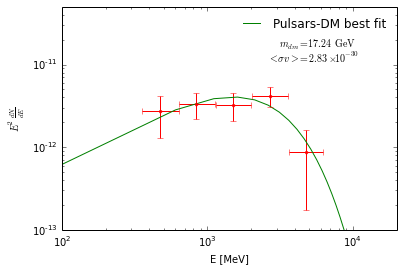

In [11]:
N0_bf2,mdm_bf2, sigv_bf2,Jfac_bf2 = result2["x"]
fig3=pl.figure()
ax3= fig3.add_subplot(111)
ax3.plot(En,composite(En,[N0_bf2,mdm_bf2, sigv_bf2,Jfac_bf2]),'green',label='Pulsars-DM best fit')
ax3.annotate(r'$m_{dm}=17.24 \,{\rm GeV}$',xy=(0.65,0.82),xycoords='axes fraction')
ax3.annotate(r'$\quad <\sigma v>=2.83\times 10^{-30}$',xy=(0.575,0.75),xycoords='axes fraction')
#ax3.plot(En,Ebb(En,[mdm_bf2, sigv_bf2,Jfac_bf2]),'--b')
#ax3.plot(En,E2dNdEpulsar(En,N0_bf2),'--k')
ax3= fig3.add_subplot(111)
ax3.errorbar(x,y,xerr=[dx_low,dx_up],yerr=[dy_low,dy_up],fmt='.r')
ax3.legend(loc='upper right',frameon=False)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_ylim([1e-13,5e-11])
ax3.set_xlim([100,20000])
ax3.set_xlabel('E [MeV]')
ax3.set_ylabel(r'$E^2 \frac{dN}{dE}$')

To add a non-negligible contribution of the Dark Matter to the spectra I should leave the normalization of the pulsar espectra as
a free parameter  as well as the Jfactor. Then I have 4 free parameters to adjust 5 points... The simple minimization of the chisq gives the following parameters, but so few points I'm not sure I can conclude much:

$N0=3.73 \times 10^{-13}$

$m_{\rm dm}=17240.95 {\rm[ MeV]}$

$<\sigma v >=2.97\times10^{-30}$

$J_{\rm fac}=2.23 \times10^{22}$

A simple comparison of the chisquare shows that the model of pulsars plus dm is sligthly better. To say so more formally I have to do a more extensive analysis:

$\chi^2_{\rm pulsar}=0.2$

$\chi^2_{\rm dm}=3.43$

$\chi^2_{\rm pulsar+dm}=0.18$

Here I do the analysis for the combined spectra but fixing J. 

In [27]:
jfac=1.34e19
def lnlike2(theta,jfac,x,y,yerr):
    N0_,mdm_, sigv_ = theta
    model= E2dNdEpulsar(x,N0_)+Ebb(x,[mdm_,sigv_,jfac])
    inv_sigma2 = 1.0/np.power(yerr,2.)
    lnlike=-0.5*(np.sum((np.power(y-model,2.)*inv_sigma2) - np.log(inv_sigma2)))
    return lnlike

chi2 = lambda *args: -2 * lnlike2(*args)
result2 = op.minimize(chi2, [N0_start,mdm_start,sigmav_start], 
                     args=(jfac,x, y, yerr),method='Nelder-Mead')

def composite(x,theta):
     N0_,mdm_, sigv_,jfac_ = theta
     model= E2dNdEpulsar(x,N0_)+Ebb(x,[mdm_,sigv_,jfac_])
     return model
print(result2['x'][0],result2['x'][1],result2['x'][2])
print(ChiSq(composite,[result2['x'][0],result2['x'][1],result2['x'][2],jfac],x,y,yerr))

(4.1148766429796522e-13, 2393.0526452090444, 4.947138493434438e-27)
0.162574501987


The results are : 
    
$N_0=3.72\times 10^{-13}$

$m_{\rm dm}=17.24 \rm{GeV}$

$<\sigma v >=4.96\times10^{-32}$

$\chi^2_{pulsar+dm}=0.18$

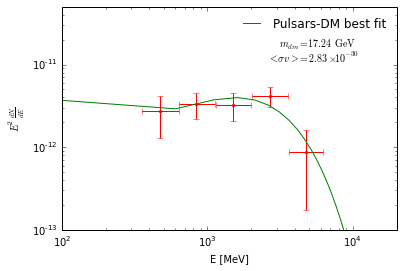

In [28]:
N0_bf4,mdm_bf4, sigv_bf4 = result2["x"]
fig4=pl.figure()
ax4= fig4.add_subplot(111)
ax4.plot(En,composite(En,[N0_bf4,mdm_bf4, sigv_bf4,jfac]),'green',label='Pulsars-DM best fit')
ax4.plot(En,)
ax4.annotate(r'$m_{dm}=17.24 \,{\rm GeV}$',xy=(0.65,0.82),xycoords='axes fraction')
ax4.annotate(r'$\quad <\sigma v>=2.83\times 10^{-30}$',xy=(0.575,0.75),xycoords='axes fraction')
#ax3.plot(En,Ebb(En,[mdm_bf2, sigv_bf2,Jfac_bf2]),'--b')
#ax3.plot(En,E2dNdEpulsar(En,N0_bf2),'--k')
ax4= fig4.add_subplot(111)
ax4.errorbar(x,y,xerr=[dx_low,dx_up],yerr=[dy_low,dy_up],fmt='.r')
ax4.legend(loc='upper right',frameon=False)
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_ylim([1e-13,5e-11])
ax4.set_xlim([100,20000])
ax4.set_xlabel('E [MeV]')
ax4.set_ylabel(r'$E^2 \frac{dN}{dE}$')